In [4]:
import torch
print(torch.__version__)


2.5.1+cpu


In [18]:
import logging

logging.basicConfig(level=logging.INFO)


## КОД ЯКИЙ ПРАЦЮЄ


In [29]:
from transformers import logging
logging.set_verbosity_debug()
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')


loading file vocab.txt from cache at C:\Users\zahid\.cache\huggingface\hub\models--bert-base-multilingual-cased\snapshots\3f076fdb1ab68d5b2880cb87a0886f315b8146f8\vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at C:\Users\zahid\.cache\huggingface\hub\models--bert-base-multilingual-cased\snapshots\3f076fdb1ab68d5b2880cb87a0886f315b8146f8\tokenizer_config.json
loading file tokenizer.json from cache at C:\Users\zahid\.cache\huggingface\hub\models--bert-base-multilingual-cased\snapshots\3f076fdb1ab68d5b2880cb87a0886f315b8146f8\tokenizer.json
loading configuration file config.json from cache at C:\Users\zahid\.cache\huggingface\hub\models--bert-base-multilingual-cased\snapshots\3f076fdb1ab68d5b2880cb87a0886f315b8146f8\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropou

loading file vocab.txt from cache at C:\Users\zahid\.cache\huggingface\hub\models--bert-base-multilingual-cased\snapshots\3f076fdb1ab68d5b2880cb87a0886f315b8146f8\vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at C:\Users\zahid\.cache\huggingface\hub\models--bert-base-multilingual-cased\snapshots\3f076fdb1ab68d5b2880cb87a0886f315b8146f8\tokenizer_config.json
loading file tokenizer.json from cache at C:\Users\zahid\.cache\huggingface\hub\models--bert-base-multilingual-cased\snapshots\3f076fdb1ab68d5b2880cb87a0886f315b8146f8\tokenizer.json
loading configuration file config.json from cache at C:\Users\zahid\.cache\huggingface\hub\models--bert-base-multilingual-cased\snapshots\3f076fdb1ab68d5b2880cb87a0886f315b8146f8\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropou

Кластери документів: [2 2 0 1 0 1]
Мітки тем: {0: 'Der Klimawandel beeinflusst | Aufgrund der jüngsten', 1: 'Технології штучного інтелекту | Machine learning is', 2: 'Wyścigi to dynamiczna | wyścigach torowych, każda'}
Тема документа 'Wyścigi to dynamiczna i pełna emocji forma sportu, która przyciąga miliony fanów na całym świecie., Niezależnie od tego, czy mówimy o Formule 1, rajdach samochodowych, motocyklowych czy': Wyścigi to dynamiczna | wyścigach torowych, każda
Тема документа 'wyścigach torowych, każda forma rywalizacji zapewnia niesamowite wrażenia i adrenaliny.': Wyścigi to dynamiczna | wyścigach torowych, każda
Тема документа 'Der Klimawandel beeinflusst das Wetter auf der ganzen Welt. Es werden vermehrt extreme Wetterereignisse beobachtet.': Der Klimawandel beeinflusst | Aufgrund der jüngsten
Тема документа 'Технології штучного інтелекту активно змінюють багато галузей, включаючи медицину та фінанси.': Технології штучного інтелекту | Machine learning is
Тема документа 'Aufgr

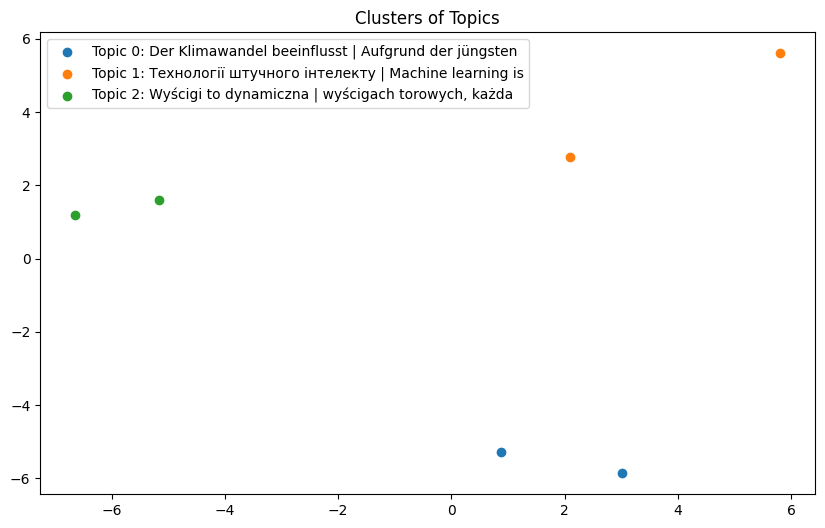

In [ ]:
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


class BERTTopicModeler:
    def __init__(self, num_topics=5):
        """
        Ініціалізація моделі BERT для виявлення тем.
        
        :param num_topics: Кількість тем для кластеризації.
        """
        self.num_topics = num_topics
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
        self.model = BertModel.from_pretrained('bert-base-multilingual-cased')
        self.kmeans = None
        self.topic_labels = {}

    def encode_texts(self, texts):
        """
        Генерує векторні уявлення для текстів за допомогою BERT.
        
        :param texts: Список текстів (документів).
        :return: Матриця векторів для текстів.
        """
        embeddings = []
        for text in texts:
            # Токенізація тексту
            inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
            with torch.no_grad():
                # Отримання векторів
                outputs = self.model(**inputs)
            embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
        return np.array(embeddings)

    def fit_cluster_model(self, embeddings, texts):
        """
        Навчає модель KMeans на векторах текстів.
        
        :param embeddings: Матриця векторів текстів.
        :param texts: Список текстів, що використовуються для створення міток тем.
        """
        self.kmeans = KMeans(n_clusters=self.num_topics, random_state=42)
        self.kmeans.fit(embeddings)

        # Визначення назв тем на основі прикладів із кожного кластера
        cluster_texts = {i: [] for i in range(self.num_topics)}
        for text, label in zip(texts, self.kmeans.labels_):
            cluster_texts[label].append(text)

        # Встановлюємо мітки тем як перші 3 слова з текстів кластерів
        self.topic_labels = {
            cluster: " | ".join([" ".join(text.split()[:3]) for text in cluster_texts[cluster][:2]])
            for cluster in range(self.num_topics)
        }

    def predict_topic(self, text):
        """
        Визначає тему для нового тексту.
        
        :param text: Текст для аналізу.
        :return: Назва теми.
        """
        if not self.kmeans:
            raise ValueError("Кластерна модель ще не навчена. Використовуйте fit_cluster_model спочатку.")
        
        # Генеруємо вектор для нового тексту
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
        with torch.no_grad():
            outputs = self.model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy().reshape(1, -1)
        
        # Використання натренованої моделі для передбачення
        cluster_id = self.kmeans.predict(embedding)[0]
        return self.topic_labels.get(cluster_id, "Unknown topic")

    def visualize_clusters(self, embeddings, clusters):
        """
        Візуалізує кластери на 2D-просторі.
        
        :param embeddings: Матриця векторів текстів.
        :param clusters: Список кластерів.
        """
        pca = PCA(n_components=2)
        reduced_embeddings = pca.fit_transform(embeddings)
        
        plt.figure(figsize=(10, 6))
        for cluster in range(self.num_topics):
            points = reduced_embeddings[np.array(clusters) == cluster]
            plt.scatter(points[:, 0], points[:, 1], label=f"Topic {cluster}: {self.topic_labels.get(cluster, '')}")
        plt.title("Clusters of Topics")
        plt.legend()
        plt.show()



if __name__ == "__main__":
    
    documents = [

        "Wyścigi to dynamiczna i pełna emocji forma sportu, która przyciąga miliony fanów na całym świecie., "
        "Niezależnie od tego, czy mówimy o Formule 1, rajdach samochodowych, motocyklowych czy",
        "wyścigach torowych, każda forma rywalizacji zapewnia niesamowite wrażenia i adrenaliny.",
        "Der Klimawandel beeinflusst das Wetter auf der ganzen Welt. Es werden vermehrt extreme Wetterereignisse beobachtet.",
        "Технології штучного інтелекту активно змінюють багато галузей, включаючи медицину та фінанси.",
        "Aufgrund der jüngsten wirtschaftlichen Ereignisse kam es auf dem Finanzmarkt zu erheblichen Schwankungen",
        "Machine learning is an important part of today's innovation in technology",
    ]
    
    # Створення об'єкта для аналізу
    topic_modeler = BERTTopicModeler(num_topics=3)
    
    # Генерація векторів
    embeddings = topic_modeler.encode_texts(documents)
    
    # Навчання кластерної моделі
    topic_modeler.fit_cluster_model(embeddings, documents)
    
    # Визначення тем для документів
    clusters = topic_modeler.kmeans.labels_
    print("Кластери документів:", clusters)
    print("Мітки тем:", topic_modeler.topic_labels)
    
    # Визначення тем для кожного документа
    for i, doc in enumerate(documents):
        topic = topic_modeler.predict_topic(doc)
        print(f"Тема документа '{doc}': {topic}")
    
    # Візуалізація
    topic_modeler.visualize_clusters(embeddings, clusters)


In [47]:
pip install spacy


Note: you may need to restart the kernel to use updated packages.


## ПОКРАЩЕНИЙ КОД

Кластери документів: [2 5 0 3 4 1]
Мітки тем: {0: 'Der Klimawandel', 1: 'Machine', 2: 'emocji forma', 3: 'штучного', 4: 'Ereignisse', 5: 'wyścigach'}
Тема документа 'Wyścigi to dynamiczna i pełna emocji forma sportu, która przyciąga miliony fanów na całym świecie., Niezależnie od tego, czy mówimy o Formule 1, rajdach samochodowych, motocyklowych czy': emocji forma
Тема документа 'wyścigach torowych, każda форма rywalizacji zapewnia niesamowite wrażenia i adrenaliny.': wyścigach
Тема документа 'Der Klimawandel beeinflusst das Wetter auf der ganzen Welt. Es werden vermehrt extreme Wetterereignisse beobachtet.': Der Klimawandel
Тема документа 'Технології штучного інтелекту активно змінюють багато галузей, включаючи медицину та фінанси.': штучного
Тема документа 'Aufgrund der jüngsten wirtschaftlichen Ereignisse kam es auf dem Finanzmarkt zu erheblichen Schwankungen': Ereignisse
Тема документа 'Machine learning is an important part of today's innovation in technology': Machine


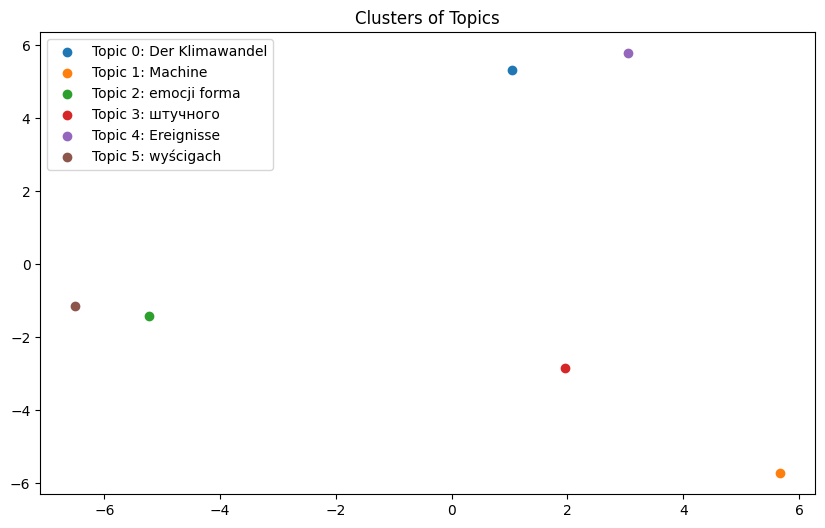

In [2]:
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import spacy

class BERTTopicModeler:
    def __init__(self, num_topics=10):
        """
        Ініціалізація моделі BERT для виявлення тем.
        
        :param num_topics: Кількість тем для кластеризації.
        """
        self.num_topics = num_topics
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
        self.model = BertModel.from_pretrained('bert-base-multilingual-cased')
        self.kmeans = None
        self.topic_labels = {}
        self.nlp = spacy.load("en_core_web_sm")  

    def encode_texts(self, texts):
        """
        Генерує векторні уявлення для текстів за допомогою BERT.
        
        :param texts: Список текстів (документів).
        :return: Матриця векторів для текстів.
        """
        embeddings = []
        for text in texts:
            
            inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
            with torch.no_grad():
                
                outputs = self.model(**inputs)
            embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
        return np.array(embeddings)

    def fit_cluster_model(self, embeddings, texts):
        """
        Навчає модель KMeans на векторах текстів.
        
        :param embeddings: Матриця векторів текстів.
        :param texts: Список текстів, що використовуються для створення міток тем.
        """
        self.kmeans = KMeans(n_clusters=self.num_topics, random_state=42)
        self.kmeans.fit(embeddings)

        
        cluster_centroids = self.kmeans.cluster_centers_
        self.topic_labels = {}

        for i, centroid in enumerate(cluster_centroids):
            similarities = cosine_similarity([centroid], embeddings)
            sorted_idx = similarities.argsort()[0][::-1]  

            
            top_doc = texts[sorted_idx[0]]
            
            self.topic_labels[i] = self.extract_main_concept(top_doc)

    def extract_main_concept(self, text):
        """
        Виділяє основне слово або концепцію з тексту, що представляє тему.
        
        :param text: Текст для аналізу.
        :return: Ключове слово або концепція.
        """
        doc = self.nlp(text)
        entities = [ent.text for ent in doc.ents if ent.label_ in ['ORG', 'PERSON', 'GPE', 'EVENT', 'PRODUCT']]
        
        if not entities:
            entities = [token.text for token in doc if token.pos_ in ['NOUN', 'PROPN']]
        
        main_concept = Counter(entities).most_common(1)
        return main_concept[0][0] if main_concept else "Unknown concept"

    def predict_topic(self, text):
        """
        Визначає тему для нового тексту.
        
        :param text: Текст для аналізу.
        :return: Назва теми.
        """
        if not self.kmeans:
            raise ValueError("Кластерна модель ще не навчена. Використовуйте fit_cluster_model спочатку.")
        
        
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
        with torch.no_grad():
            outputs = self.model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy().reshape(1, -1)
        
        
        cluster_id = self.kmeans.predict(embedding)[0]
        return self.topic_labels.get(cluster_id, "Unknown topic")

    def visualize_clusters(self, embeddings, clusters):
        """
        Візуалізує кластери на 2D-просторі.
        
        :param embeddings: Матриця векторів текстів.
        :param clusters: Список кластерів.
        """
        pca = PCA(n_components=2)
        reduced_embeddings = pca.fit_transform(embeddings)
        
        plt.figure(figsize=(10, 6))
        for cluster in range(self.num_topics):
            points = reduced_embeddings[np.array(clusters) == cluster]
            plt.scatter(points[:, 0], points[:, 1], label=f"Topic {cluster}: {self.topic_labels.get(cluster, '')}")
        plt.title("Clusters of Topics")
        plt.legend()
        plt.show()


if __name__ == "__main__":
    
    documents = [
        "Wyścigi to dynamiczna i pełna emocji forma sportu, która przyciąga miliony fanów na całym świecie., "
        "Niezależnie od tego, czy mówimy o Formule 1, rajdach samochodowych, motocyklowych czy",
        "wyścigach torowych, każda форма rywalizacji zapewnia niesamowite wrażenia i adrenaliny.",
        "Der Klimawandel beeinflusst das Wetter auf der ganzen Welt. Es werden vermehrt extreme Wetterereignisse beobachtet.",
        "Технології штучного інтелекту активно змінюють багато галузей, включаючи медицину та фінанси.",
        "Aufgrund der jüngsten wirtschaftlichen Ereignisse kam es auf dem Finanzmarkt zu erheblichen Schwankungen",
        "Machine learning is an important part of today's innovation in technology",
    ]
    
    
    topic_modeler = BERTTopicModeler(num_topics=6)
    embeddings = topic_modeler.encode_texts(documents)
    

    topic_modeler.fit_cluster_model(embeddings, documents)
    
    
    clusters = topic_modeler.kmeans.labels_
    print("Кластери документів:", clusters)
    print("Мітки тем:", topic_modeler.topic_labels)
    
    
    for i, doc in enumerate(documents):
        topic = topic_modeler.predict_topic(doc)
        print(f"Тема документа '{doc}': {topic}")
    
    
    topic_modeler.visualize_clusters(embeddings, clusters)


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats  


In [26]:
!pip install transformers torch spacy scikit-learn matplotlib



In [28]:
!python -m spacy download en_core_web_sm


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [34]:
pip install torch transformers sklearn spacy matplotlib


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

In [ ]:
pip install ipywidgets


   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.3 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.3 MB 1.1 MB/s eta 0:00:02
   ------------- -------------------------- 0.8/2.3 MB 1.2 MB/s eta 0:00:02
   ----------------- ---------------------- 1.0/2.3 MB 1.2 MB/s eta 0:00:02
   ---------------------- ----------------- 1.3/2.3 MB 1.2 MB/s eta 0:00:01
   -------------------------- ------------- 1.6/2.3 MB 1.3 MB/s eta 0:00:01
   ------------------------------- -------- 1.8/2.3 MB 1.3 MB/s eta 0:00:01
   ----------------------------------- ---- 2.1/2.3 MB 1.1 MB/s eta 0:00:01
   ----------------------------------- ---- 2.1/2.3 MB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [56]:
import csv
from transformers import pipeline

class TextClassifier:
    def __init__(self, model_name='bert-base-uncased', task='zero-shot-classification'):
        """
        Ініціалізуємо клас для класифікації тексту.
        
        :param model_name: Назва моделі для завантаження
        :param task: Тип завдання (класифікація без навчання)
        """
        self.classifier = pipeline(task, model=model_name)

    def classify_text(self, text, candidate_labels):
        """
        Класифікує текст за допомогою попередньо навченого AI.

        :param text: Текст для класифікації
        :param candidate_labels: Список можливих тем для класифікації
        :return: Результат класифікації
        """
        return self.classifier(text, candidate_labels)

    def save_results_to_csv(self, results, filename='classification_results.csv'):
        """
        Зберігає результати класифікації в CSV файл.

        :param results: Список результатів класифікації
        :param filename: Назва файлу для збереження
        """
        keys = results[0].keys()  # Отримуємо заголовки для CSV з перших результатів
        with open(filename, mode='w', newline='', encoding='utf-8') as file:
            writer = csv.DictWriter(file, fieldnames=keys)
            writer.writeheader()
            writer.writerows(results)
        print(f"Results saved to {filename}")

# Використання класу
if __name__ == "__main__":
    # Ініціалізуємо об'єкт для класифікації тексту
    classifier = TextClassifier()

    # Список текстів для аналізу
    texts = [
        "The stock market is facing some uncertainty due to new financial regulations.",
        "AI technologies are revolutionizing the healthcare industry."
    ]

    # Список можливих тем для класифікації
    candidate_labels = ['economics', 'politics', 'technology', 'healthcare']

    # Класифікація кількох текстів
    results = []
    for text in texts:
        result = classifier.classify_text(text, candidate_labels)
        results.append({
            'text': text,
            'predicted_topic': result['labels'][0],
            'confidence_score': result['scores'][0]
        })

    # Збереження результатів у CSV файл
    classifier.save_results_to_csv(results)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


Results saved to classification_results.csv


In [57]:
df = pd.read_csv(
    'C:/Users/zahid/Desktop/політех/СМП/classification_results.csv'
)

In [58]:
df.head()

,text,predicted_topic,confidence_score
0,The stock market is facing some uncertainty du...,economics,0.295583
1,AI technologies are revolutionizing the health...,healthcare,0.285599


Кластери документів: [2 0 1]
Мітки тем: {0: 'weather', 1: 'Машинне', 2: 'Artificial Intelligence (AI'}
Тема документа 'Artificial Intelligence (AI) is transforming the m...': Artificial Intelligence (AI
Тема документа 'Global warming is a critical issue affecting weath...': weather
Тема документа '
        Машинне навчання — це потужний інструмент...': Машинне


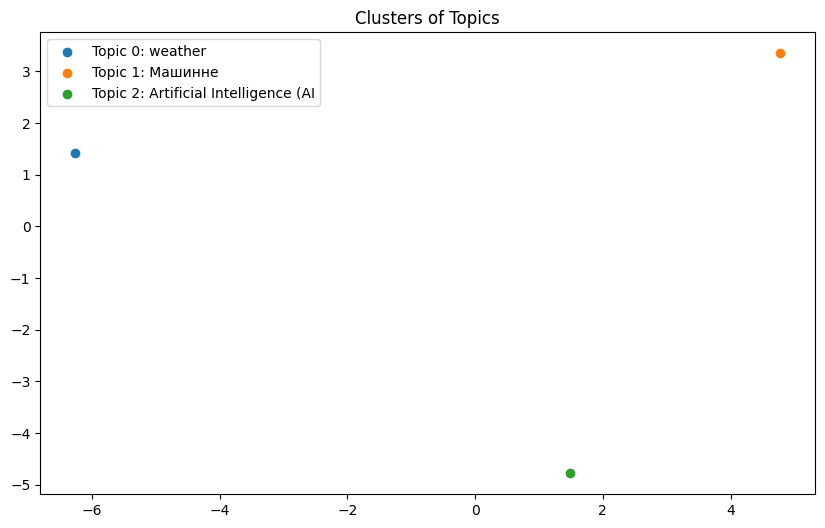

In [4]:
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import spacy

class BERTTopicModeler:
    def __init__(self, num_topics=10):
        """
        Ініціалізація моделі BERT для виявлення тем.
        
        :param num_topics: Кількість тем для кластеризації.
        """
        self.num_topics = num_topics
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
        self.model = BertModel.from_pretrained('bert-base-multilingual-cased')
        self.kmeans = None
        self.topic_labels = {}
        self.nlp = spacy.load("en_core_web_sm")  

    def encode_texts(self, texts):
        """
        Генерує векторні уявлення для текстів за допомогою BERT.
        
        :param texts: Список текстів (документів).
        :return: Матриця векторів для текстів.
        """
        embeddings = []
        for text in texts:
            chunks = [text[i:i + 512] for i in range(0, len(text), 512)]  # Розбити довгі тексти
            chunk_embeddings = []
            
            for chunk in chunks:
                inputs = self.tokenizer(chunk, return_tensors='pt', padding=True, truncation=True, max_length=128)
                with torch.no_grad():
                    outputs = self.model(**inputs)
                chunk_embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
            
            # Агрегувати вектори частин тексту
            full_embedding = np.mean(chunk_embeddings, axis=0)
            embeddings.append(full_embedding)
        
        return np.array(embeddings)

    def fit_cluster_model(self, embeddings, texts):
        """
        Навчає модель KMeans на векторах текстів.
        
        :param embeddings: Матриця векторів текстів.
        :param texts: Список текстів, що використовуються для створення міток тем.
        """
        self.kmeans = KMeans(n_clusters=self.num_topics, random_state=42)
        self.kmeans.fit(embeddings)

        cluster_centroids = self.kmeans.cluster_centers_
        self.topic_labels = {}

        for i, centroid in enumerate(cluster_centroids):
            similarities = cosine_similarity([centroid], embeddings)
            sorted_idx = similarities.argsort()[0][::-1]  

            top_doc = texts[sorted_idx[0]]
            self.topic_labels[i] = self.extract_main_concept(top_doc)

    def extract_main_concept(self, text):
        """
        Виділяє основне слово або концепцію з тексту, що представляє тему.
        
        :param text: Текст для аналізу.
        :return: Ключове слово або концепція.
        """
        doc = self.nlp(text)
        entities = [ent.text for ent in doc.ents if ent.label_ in ['ORG', 'PERSON', 'GPE', 'EVENT', 'PRODUCT']]
        
        if not entities:
            entities = [token.text.lower() for token in doc if token.pos_ in ['NOUN', 'PROPN']]
        
        main_concept = Counter(entities).most_common(1)
        return main_concept[0][0] if main_concept else "Unknown"

    def predict_topic(self, text):
        """
        Визначає тему для нового тексту.
        
        :param text: Текст для аналізу.
        :return: Назва теми.
        """
        if not self.kmeans:
            raise ValueError("Кластерна модель ще не навчена. Використовуйте fit_cluster_model спочатку.")
        
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
        with torch.no_grad():
            outputs = self.model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy().reshape(1, -1)
        
        cluster_id = self.kmeans.predict(embedding)[0]
        return self.topic_labels.get(cluster_id, "Unknown")

    def visualize_clusters(self, embeddings, clusters):
        """
        Візуалізує кластери на 2D-просторі.
        
        :param embeddings: Матриця векторів текстів.
        :param clusters: Список кластерів.
        """
        pca = PCA(n_components=2)
        reduced_embeddings = pca.fit_transform(embeddings)
        
        plt.figure(figsize=(10, 6))
        for cluster in range(self.num_topics):
            points = reduced_embeddings[np.array(clusters) == cluster]
            plt.scatter(points[:, 0], points[:, 1], label=f"Topic {cluster}: {self.topic_labels.get(cluster, '')}")
        plt.title("Clusters of Topics")
        plt.legend()
        plt.show()

if __name__ == "__main__":
    # Вхідні дані
    documents = [
        """Artificial Intelligence (AI) is transforming the modern world, influencing everything from
        medicine to finance. Companies like OpenAI and Google are at the forefront of AI innovation...""",
        """Global warming is a critical issue affecting weather patterns worldwide. Reports show that
        rising temperatures are leading to extreme weather events...""",
        """
        Машинне навчання — це потужний інструмент, який трансформує світ,автоматизуючи процеси, підвищуючи ефективність і створюючи нові можливості. 
        Однак, для його впровадження потрібні великі обсяги даних, обчислювальні ресурси та досвід у розробці моделей. 
        У майбутньому роль машинного навчання лише зростатиме, відкриваючи нові горизонти для науки й технологій.
        """
    ]
    
    # Ініціалізація та навчання
    topic_modeler = BERTTopicModeler(num_topics=3)
    embeddings = topic_modeler.encode_texts(documents)
    topic_modeler.fit_cluster_model(embeddings, documents)
    
    # Виведення кластерів і назв тем
    clusters = topic_modeler.kmeans.labels_
    print("Кластери документів:", clusters)
    print("Мітки тем:", topic_modeler.topic_labels)
    
    # Виведення тем для кожного документа
    for i, doc in enumerate(documents):
        topic = topic_modeler.predict_topic(doc)
        print(f"Тема документа '{doc[:50]}...': {topic}")
    
    # Візуалізація кластерів
    topic_modeler.visualize_clusters(embeddings, clusters)


Кластери документів: [2 0 1]
Мітки тем: {0: 'weather, affecting, critical', 1: 'для, навчання, нові', 2: 'ai, artificial, companies'}
Тема документа 'Artificial Intelligence (AI) is transforming the m...': ai, artificial, companies
Тема документа 'Global warming is a critical issue affecting weath...': weather, affecting, critical
Тема документа '
        Машинне навчання — це потужний інструмент...': для, навчання, нові


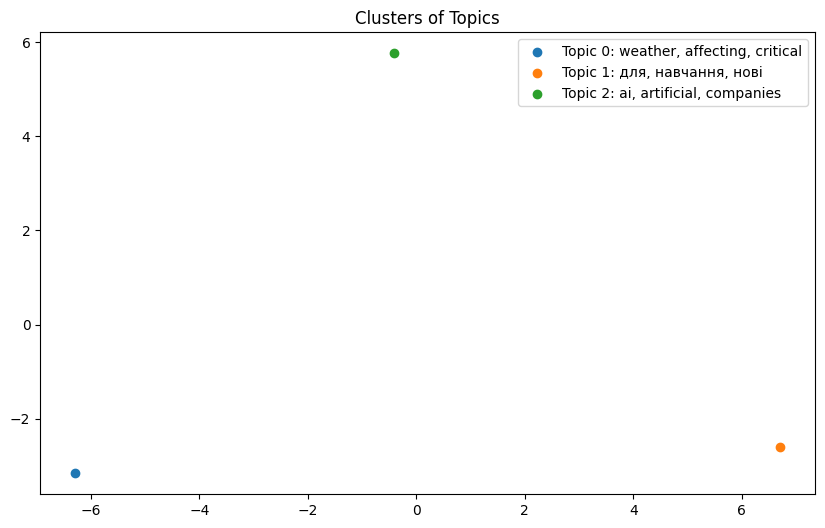

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

class BERTTopicModeler:
    def __init__(self, num_topics=10):
        self.num_topics = num_topics
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
        self.model = BertModel.from_pretrained('bert-base-multilingual-cased')
        self.kmeans = None
        self.topic_labels = {}
        self.nlp = spacy.load("en_core_web_sm")

    def preprocess_text(self, texts):
        processed_texts = []
        for text in texts:
            doc = self.nlp(text)
            tokens = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct]
            processed_texts.append(" ".join(tokens))
        return processed_texts

    def encode_texts(self, texts):
        embeddings = []
        for text in texts:
            chunks = [text[i:i + 512] for i in range(0, len(text), 512)]
            chunk_embeddings = []
            
            for chunk in chunks:
                inputs = self.tokenizer(chunk, return_tensors='pt', padding=True, truncation=True, max_length=128)
                with torch.no_grad():
                    outputs = self.model(**inputs)
                chunk_embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
            
            full_embedding = np.mean(chunk_embeddings, axis=0)
            embeddings.append(full_embedding)
        
        return np.array(embeddings)

    def fit_cluster_model(self, embeddings, texts):
        self.kmeans = KMeans(n_clusters=self.num_topics, random_state=42, n_init=10)
        self.kmeans.fit(embeddings)

        cluster_texts = {i: [] for i in range(self.num_topics)}
        for text, cluster in zip(texts, self.kmeans.labels_):
            cluster_texts[cluster].append(text)

        self.topic_labels = {}
        for cluster, cluster_docs in cluster_texts.items():
            self.topic_labels[cluster] = self.extract_main_concepts(cluster_docs)

    def extract_main_concepts(self, texts):
        vectorizer = TfidfVectorizer(max_features=10, stop_words='english')
        tfidf_matrix = vectorizer.fit_transform(texts)
        feature_array = vectorizer.get_feature_names_out()
        tfidf_scores = tfidf_matrix.sum(axis=0).A1
        top_terms = sorted(zip(feature_array, tfidf_scores), key=lambda x: x[1], reverse=True)[:3]
        return ", ".join([term for term, _ in top_terms])

    def predict_topic(self, text):
        if not self.kmeans:
            raise ValueError("Кластерна модель ще не навчена. Використовуйте fit_cluster_model спочатку.")
        
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
        with torch.no_grad():
            outputs = self.model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy().reshape(1, -1)
        
        cluster_id = self.kmeans.predict(embedding)[0]
        return self.topic_labels.get(cluster_id, "Unknown")

    def visualize_clusters(self, embeddings, clusters):
        pca = PCA(n_components=2)
        reduced_embeddings = pca.fit_transform(embeddings)
        
        plt.figure(figsize=(10, 6))
        for cluster in range(self.num_topics):
            points = reduced_embeddings[np.array(clusters) == cluster]
            plt.scatter(points[:, 0], points[:, 1], label=f"Topic {cluster}: {self.topic_labels.get(cluster, '')}")
        plt.title("Clusters of Topics")
        plt.legend()
        plt.show()

if __name__ == "__main__":
    documents = [
        """Artificial Intelligence (AI) is transforming the modern world, influencing everything from
        medicine to finance. Companies like OpenAI and Google are at the forefront of AI innovation...""",
        """Global warming is a critical issue affecting weather patterns worldwide. Reports show that
        rising temperatures are leading to extreme weather events...""",
        """
        Машинне навчання — це потужний інструмент, який трансформує світ,автоматизуючи процеси, підвищуючи ефективність і створюючи нові можливості. 
        Однак, для його впровадження потрібні великі обсяги даних, обчислювальні ресурси та досвід у розробці моделей. 
        У майбутньому роль машинного навчання лише зростатиме, відкриваючи нові горизонти для науки й технологій.
        """
    ]
    
    topic_modeler = BERTTopicModeler(num_topics=3)
    preprocessed_documents = topic_modeler.preprocess_text(documents)
    embeddings = topic_modeler.encode_texts(preprocessed_documents)
    topic_modeler.fit_cluster_model(embeddings, documents)
    
    clusters = topic_modeler.kmeans.labels_
    print("Кластери документів:", clusters)
    print("Мітки тем:", topic_modeler.topic_labels)
    
    for i, doc in enumerate(documents):
        topic = topic_modeler.predict_topic(doc)
        print(f"Тема документа '{doc[:50]}...': {topic}")
    
    topic_modeler.visualize_clusters(embeddings, clusters)
